# 0.0. Understanding the problem

--Goal:
    
    --1.0 Predict the first destination that the new user will choose
    
    --Why?
        --What is the business model of Airbnb?
            --Marketplace (connect people who offer acomodation to whom are seeking a place)
            --Offer
                --Portfolio size
                --Portfolio diversity and density
                --Average price
                
            --Demand
                --Number of users
                --LTV (lifetime value)
                --CAC (client acquisition cost)
                
                Gross Revenue = (Fee*Number of clients) - CAC
                
--Solution:
    
    --Predictive model for the first destination of new user
    --1.0 Prediction save in a database
    --2.0 API
        --Input: User and features
        --Output: User and feature with destination prediction
        

# Module 1

## 0.0. Imports

In [54]:
#!pip install keras
#!pip install tensorflow
#!pip install scikit-plot
#!pip install imblearn
#!pip install delayed
#!pip install pandas-profiling
#!pip install matplotlib

import random
import pickle

import numpy   as np
import pandas  as pd
import seaborn as sns

from sklearn    import model_selection as ms
from sklearn    import preprocessing   as pp
from sklearn    import metrics         as m
from scikitplot import metrics         as mt
from scipy      import stats           as ss
from imblearn   import under_sampling  as us
from imblearn   import over_sampling   as oversamp
from imblearn   import combine         as c
from keras      import models          as ml
from keras      import layers          as l
from matplotlib import pyplot          as plt

from pandas_profiling import ProfileReport

### 0.1. Helper Functions

In [2]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

### 0.2. Loading Data

In [3]:
df_raw = pd.read_csv('dataset/train_users_2.csv', low_memory=True)
df_raw.shape

(213451, 16)

In [4]:
df_sessions = pd.read_csv('dataset/sessions.csv', low_memory=True)
df_sessions.shape

(10567737, 6)

# 1.0. Data Description

In [5]:
df1 = df_raw.copy()

## 1.1. Data Dimensions

In [6]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 213451
Number of columns: 16


In [7]:
print('Number of rows: {}'.format(df_sessions.shape[0]))
print('Number of columns: {}'.format(df_sessions.shape[1]))

Number of rows: 10567737
Number of columns: 6


## 1.2. Data Type

In [8]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [9]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.3. NA Check

In [10]:
df1.isna().sum()/len(df1)

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [11]:
df_sessions.isna().sum()/len(df_sessions)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

In [12]:
#date_first_booking
date_first_booking_max = pd.to_datetime(df1['date_first_booking']).max().strftime('%Y-%m-%d')
df1['date_first_booking'] = df1['date_first_booking'].fillna(date_first_booking_max)


# ========== User =================
# age
df1 = df1[( df1['age'] > 15 ) & ( df1['age'] < 120 )]
avg_age = df1['age'].mean()
df1['age'] = df1['age'].fillna( avg_age )

#first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]


# ========== Sessions =================
#user_id
df_sessions = df_sessions[~df_sessions['user_id'].isna()]

#action
df_sessions = df_sessions[~df_sessions['action'].isna()]

#action_type
df_sessions = df_sessions[~df_sessions['action_type'].isna()]

#action_detail
df_sessions = df_sessions[~df_sessions['action_detail'].isna()]

#secs_elapsed
df_sessions = df_sessions[~df_sessions['secs_elapsed'].isna()]

## 1.4. Change Data Type

In [13]:
 df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [14]:
#date_account_created
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'])

#timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format='%Y%m%d%H%M%S')

#date_first_booking
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])

#age
df1['age'] = df1['age'].astype(int)

## 1.5. Check Balanced Data

In [15]:
df1['country_destination'].value_counts(normalize=True)

NDF      0.447275
US       0.391867
other    0.061246
FR       0.029918
IT       0.016423
GB       0.014335
ES       0.013740
CA       0.008676
DE       0.006858
NL       0.004852
AU       0.003531
PT       0.001280
Name: country_destination, dtype: float64

## 1.6. Descriptive Analysis

In [16]:
#Users
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])
time_attributes = df1.select_dtypes(include=['datetime64[ns]'])

#Sessions
num_attributes_sessions = df_sessions.select_dtypes(include=['int64','float64'])
cat_attributes_sessions = df_sessions.select_dtypes(exclude=['int64','float64','datetime64[ns]'])
time_attributes_sessions = df_sessions.select_dtypes(include=['datetime64[ns]'])

### 1.6.1 Numerical - Users

In [17]:
#Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#Concat
ct = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,signup_flow,0.0,25.0,25.0,2.519513,0.0,6.604696,2.705871,5.928298


### 1.6.2 Numerical - Sessions

In [18]:
#Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes_sessions.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes_sessions.apply(np.median)).T

#Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes_sessions.apply(np.std)).T
d2 = pd.DataFrame(num_attributes_sessions.apply(min)).T
d3 = pd.DataFrame(num_attributes_sessions.apply(max)).T
d4 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.kurtosis())).T

#Concat
ct = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


### 1.6.3. Categorical - Users

In [19]:
cat_attributes.drop(['id','age'], axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,122636,122636,122636,122636,122636,122636,122636,122636,122636,122636
unique,4,3,25,8,17,7,4,9,41,12
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,56362,66039,118205,79093,78954,64712,108283,57943,41778,54852


### 1.6.4 - Categorical - Sessions

In [20]:
cat_attributes_sessions.drop('user_id', axis=1).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


In [21]:
#list of attributes for Cramer's V correlation
cat_attributes_list = cat_attributes_sessions.drop('user_id', axis=1).columns.tolist()

corr_dict = {}
for i in range(len(cat_attributes_list)):
    corr_list = []
    for j in range(len(cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes_sessions[ref], cat_attributes_sessions[feat])
        
        # append a list
        corr_list.append(corr)
    
    # appende a correlation list for each ref attributs
    corr_dict[ref] = corr_list

In [22]:
corr_dict[feat]

[0.25984796015349226,
 0.08204073846721649,
 0.2196221769687879,
 1.000000705454337]

In [23]:
corr_dict[ref]

[0.25984796015349226,
 0.08204073846721649,
 0.2196221769687879,
 1.000000705454337]

<AxesSubplot:>

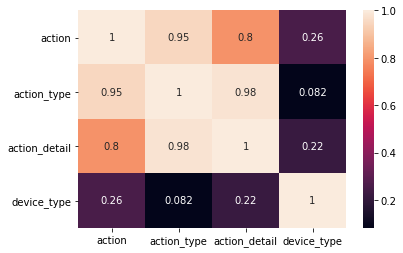

In [24]:
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
sns.heatmap(d, annot=True)

# 2.0. Feature Engineering

In [25]:
df2 = df1.copy()

## 2.1. Create New Features

In [26]:
#days from first active up to first booking
df2['first_active'] = pd.to_datetime(df2['timestamp_first_active'].dt.strftime( '%Y-%m-%d' ))
df2['days_from_frist_active_until_booking'] = (df2['date_first_booking'] - df2['first_active'] ).apply(lambda x: x.days)

#days from first active upt to account created
df2['days_from_first_active_until_account_created'] = (df2['date_account_created'] - df2['first_active']).apply(lambda x: x.days)

#days from account createad up to first booking
df2['days_from_account_created_until_first_booking'] = (df2['date_first_booking'] - df2['date_account_created']).apply(lambda x: x.days)


# ================== First Active ==================
#year first active
df2['year_first_active'] = df2['first_active'].dt.year

#month first active
df2['month_first_active'] = df2['first_active'].dt.month

#day first active
df2['day_first_active'] = df2['first_active'].dt.day

#day of week first active
df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek

#week of year first active
df2['week_of_year_first_active'] = df2['first_active'].dt.isocalendar().week
df2['week_of_year_first_active'] = np.asarray(df2['week_of_year_first_active']).astype(np.int64)


# ================== First Booking ==================
#year first booking
df2['year_first_booking'] = df2['date_first_booking'].dt.year

#month first booking
df2['month_first_booking'] = df2['date_first_booking'].dt.month

#day first booking
df2['day_first_booking'] = df2['date_first_booking'].dt.day

#day of week first booking
df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.dayofweek

#week of year first booking
df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.isocalendar().week
df2['week_of_year_first_booking'] = np.asarray(df2['week_of_year_first_booking']).astype(np.int64)


# ================== First Account Created =================
#year first booking
df2['year_account_created'] = df2['date_account_created'].dt.year

#month  account_created
df2['month_account_created'] = df2['date_account_created'].dt.month

#day  account_created
df2['day_account_created'] = df2['date_account_created'].dt.day

#day of week  account_created
df2['day_of_week_account_created'] = df2['date_account_created'].dt.dayofweek

#week of year  account_created
df2['week_of_year_account_created'] = df2['date_account_created'].dt.isocalendar().week
df2['week_of_year_account_created'] = np.asarray(df2['week_of_year_account_created']).astype(np.int64)

In [27]:
df2.dtypes

id                                                       object
date_account_created                             datetime64[ns]
timestamp_first_active                           datetime64[ns]
date_first_booking                               datetime64[ns]
gender                                                   object
age                                                       int32
signup_method                                            object
signup_flow                                               int64
language                                                 object
affiliate_channel                                        object
affiliate_provider                                       object
first_affiliate_tracked                                  object
signup_app                                               object
first_device_type                                        object
first_browser                                            object
country_destination                     

# 3.0. Data Filtering

In [28]:
df3 = df2.copy()

In [29]:
df2.head().T

,1,2,3,4,6
id,820tgsjxq7,4ft3gnwmtx,bjjt8pjhuk,87mebub9p4,lsw9q7uk0j
date_account_created,2011-05-25 00:00:00,2010-09-28 00:00:00,2011-12-05 00:00:00,2010-09-14 00:00:00,2010-01-02 00:00:00
timestamp_first_active,2009-05-23 17:48:09,2009-06-09 23:12:47,2009-10-31 06:01:29,2009-12-08 06:11:05,2010-01-02 01:25:58
date_first_booking,2015-06-29 00:00:00,2010-08-02 00:00:00,2012-09-08 00:00:00,2010-02-18 00:00:00,2010-01-05 00:00:00
gender,MALE,FEMALE,FEMALE,-unknown-,FEMALE
age,38,56,42,41,46
signup_method,facebook,basic,facebook,basic,basic
signup_flow,0,3,0,0,0
language,en,en,en,en,en
affiliate_channel,seo,direct,direct,direct,other


## 3.1. Filtering Rows

In [30]:
# Filtering rows:
# age - greater than 15 and lower than 120 - There are few people over 12O year old   
df3 = df3[( df3['age'] > 15 ) & ( df3['age'] < 120 )]

## 3.2. Columns Selection

In [31]:
cols = ['date_account_created', 'date_account_created', 'date_first_booking', 'timestamp_first_active', 'first_active'] # original datetime
df3 = df3.drop(cols, axis=1)

# 4.0. Balanced Dataset

In [32]:
df4 = df3.copy()
#df4.shape

In [33]:
#Encoder Categorical Variables
ohe = pp.OneHotEncoder()

#Numerical
col_num = df4.select_dtypes(include=['int64', 'float64']).columns.tolist()

#Categorical
col_cat = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).drop(['id', 'country_destination'], axis=1).columns.tolist()

#encoding
df4_dummy = pd.DataFrame(ohe.fit_transform( df4[ col_cat]).toarray(), index=df4.index)

#join numerical and categorical
df42 = pd.concat([df4[col_num], df4_dummy], axis=1)
df42.shape

(122636, 236)

## 4.1. Random Undersampling

In [34]:
#ratio_balanced
ratio_balanced = {'NDF': 10000}

#define sampler
undersampling = us.RandomUnderSampler(sampling_strategy=ratio_balanced, random_state=32)

#apply sampler
X_under, y_under = undersampling.fit_resample(df42, df4['country_destination'])

In [35]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [36]:
y_under.value_counts()

US       48057
NDF      10000
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

## 4.2. Random Oversampling

In [37]:
#define sampler
oversampling = oversamp.RandomOverSampler(sampling_strategy='all', random_state=32)

#apply sampler
X_over, y_over = oversampling.fit_resample(df42, df4['country_destination'])

In [38]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [39]:
y_over.value_counts()

AU       54852
other    54852
NDF      54852
GB       54852
CA       54852
DE       54852
US       54852
NL       54852
PT       54852
FR       54852
IT       54852
ES       54852
Name: country_destination, dtype: int64

## 4.3. SMOTE + TOMEKLINK

In [40]:
ratio_balanced =  {'NDF': 54852,
                   'US':  48057,
                   'other': 6*7511,
                   'FR': 12*3669,
                   'IT': 20*2014,
                   'GB': 30*1758,
                   'ES': 30*1685,
                   'CA': 40*1064,
                   'DE': 45*841,
                   'NL': 80*595,
                   'AU': 85*433,
                   'PT': 300*157}

In [41]:
#define sampler
smt = c.SMOTETomek(sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1)

In [42]:
#apply sampler
X_smt, y_smt = smt.fit_resample(df42, df4['country_destination'])

In [47]:
pickle.dump(X_smt, open('X_smt.pkl','wb'))
pickle.dump(y_smt, open('y_smt.pkl','wb'))

In [48]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [49]:
y_over.value_counts()

AU       54852
other    54852
NDF      54852
GB       54852
CA       54852
DE       54852
US       54852
NL       54852
PT       54852
FR       54852
IT       54852
ES       54852
Name: country_destination, dtype: int64

In [51]:
X_smt = pickle.load(open('C:/Users/Henrique/repos/Airbnb/airbnb_predict_first_booking/X_smt.pkl', 'rb'))
y_smt = pickle.load(open('C:/Users/Henrique/repos/Airbnb/airbnb_predict_first_booking/y_smt.pkl', 'rb'))

EOFError: Ran out of input

In [ ]:
#numerical data
df43 = X_smt[ col_num ]

#categorical data
df44 = X_smt.drop(col_num, axis=1)
df45 = pd.DataFrame(ohe.inverse_transform(df44), columns=col_cat, index=df44.index)

#join numerical categorical
df46 = pd.concat([df43, df45], axis=1)
df46['country_destination'] = y_smt

# 5.0. Exploratory Data Analysis - Insights ( Unbalanced Dataset )

In [56]:
 df51 = df46.copy()

NameError: name 'df46' is not defined

**H0.** Os usuários levem até 3 dias, em média, para fazer o cadastro no site em todos os destinos.

**Verdadeira.** Os usuários levam até 3 dias, em média para realizar o cadastro no site em todos os destinos

In [55]:
plt.figure( figsize=(25, 12))
aux01 = df5[['days_from_first_active_until_account_created', 'country_destination']].\
groupby('country_destination').mean().reset_index()
sns.barplot(x='country_destination', y='days_from_first_active_until_account_created', data=aux01);
plt.ylabel('Average days until Accout Creation');

NameError: name 'df5' is not defined

<Figure size 1800x864 with 0 Axes>

In [ ]:
proof = ProfileReport(df51)
proof.to_notebook_iframe()

# 5.0. Data Preparation

In [49]:
df5 = df4.copy()

In [50]:
#dummy variable
df5_dummy = pd.get_dummies(df5.drop(['id','country_destination'], axis=1))

#join id and country destination
df5 = pd.concat([df5[['id','country_destination']], df5_dummy], axis=1)

In [51]:
df5.shape

(122636, 140)

# 6.0. Feature Seleciotn

In [52]:
#cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking', 'first_active'] # original dates
df6 = df5.drop(cols_drop, axis=1)

KeyError: "['date_account_created' 'timestamp_first_active' 'date_first_booking'\n 'first_active'] not found in axis"

In [ ]:
X = df6.drop(['id', 'country_destination'], axis=1)
y = df6['country_destination'].copy()

In [ ]:
#split dataset into train and test
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

# 7.0. Machine Learning

## 7.1. Baseline Model

In [ ]:
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
country_destination_weights = df1['country_destination'].value_counts(normalize=True).sort_index().tolist()

yhat_random = random.choices(population=country_destination_list, 
                             weights=country_destination_weights,
                             k=k_num)

### 7.1.1. Baseline Performance

In [ ]:
#accuracy
acc_random = m.accuracy_score(y_test, yhat_random)
print('Accuracy: {}'.format(acc_random))

#balanced accuracy
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print('Balanced Accuracy: {}'.format(balanced_acc_random))

#Kappa metrics
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print('Kappa Accuracy: {}'.format(kappa_random))

#Classification report
print( m.classification_report( y_test, yhat_random ) )

#Confusion Matrix
mt.plot_confusion_matrix( y_test, yhat_random, normalize=False, figsize=(12,12))

## 7.2. Neural Network - MLP

In [ ]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()

In [ ]:
X_train.shape

In [ ]:
# model definition
model = ml.Sequential()
model.add(l.Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(l.Dense(12, activation='softmax'))

# model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model.fit(X_train, y_train_nn, epochs=100)

### 7.2.1. NN Performance

In [ ]:
#prediction
pred_nn = model.predict(X_test)

#invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)

#prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]

In [ ]:
#accuracy
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
print('Accuracy: {}'.format(acc_nn))

#balanced accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print('Balanced Accuracy: {}'.format(balanced_acc_nn))

#Kappa metrics
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print('Kappa Accuracy: {}'.format(kappa_nn))

#confusion matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(12,12))

### 7.2.2. NN Performance - Cross-Validation

In [ ]:
# generate k-fold
num_folds = 5
kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=32)

balanced_acc_list = []
kappa_acc_list = []

i = 1

for train_ix, val_ix in kfold.split(X_train, y_train):
    print('Fold Number: {}/{}'.format(i, num_folds))
    
    #get fold
    x_train_fold = X_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = X_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    #target hot-enconding
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape(-1,1)).toarray()
    
    #model definition
    model = ml.Sequential()
    model.add(l.Dense(256, input_dim=X_train.shape[1], activation='relu'))
    model.add(l.Dense(12, activation='softmax'))
    
    #compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    #training model
    model.fit(x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0)
    
    #prediction
    pred_nn = model.predict(x_val_fold)
    yhat_nn = ohe.inverse_transform(pred_nn)
    
    #prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape(1, -1)[0]
    
    #metrics
    ##Balanced Accuracy
    baanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
    balanced_acc_list.append(balanced_acc_nn)
    
    ##Kappa Metrics
    kappa_acc_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
    kappa_acc_list.append(kappa_acc_nn)
    
    i+=1


In [53]:
pickle.dump(balanced_acc_list, open('balanced_acc_list.pkl','wb'))
pickle.dump(kappa_acc_list, open('kappa_acc_list.pkl','wb'))

NameError: name 'balanced_acc_list' is not defined

In [ ]:
print('Avg Balanced Accuracy: {} +/- {}'.format(np.round(np.mean(balanced_acc_list),2),
                                                np.round(np.std(balanced_acc_list),4)))
print('Avg Kappa Accuracy: {} +/- {}'.format(np.round(np.mean(kappa_acc_list),2),
                                             np.round(np.std(kappa_acc_list)),4))